In [1]:
import sys
sys.path.append('..')

In [2]:
from pymavlink import mavutil

import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

In [3]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [4]:
RUTA_COMPLETA

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [9]:
vehiculo = 'DA02'

In [10]:
path_rec = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\RECORRIDOS_.shp'
gdf_rec = gpd.read_file(path_rec)

In [11]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

71

In [12]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

8

In [13]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [14]:
lineas, names = leer_logs(contenido_filtrado)

In [15]:
lineas

[<LINESTRING (-63.196 -17.373, -63.196 -17.373, -63.196 -17.373, -63.196 -17....>,
 <LINESTRING (-63.195 -17.401, -63.195 -17.401, -63.195 -17.401, -63.195 -17....>,
 <LINESTRING (-63.272 -17.409, -63.272 -17.409, -63.272 -17.409, -63.272 -17....>,
 <LINESTRING (-63.251 -17.4, -63.251 -17.4, -63.251 -17.4, -63.251 -17.4, -63...>,
 <LINESTRING (-63.25 -17.394, -63.25 -17.394, -63.25 -17.394, -63.25 -17.394,...>,
 <LINESTRING (-63.286 -17.27, -63.286 -17.27, -63.286 -17.27, -63.286 -17.27,...>,
 <LINESTRING (-63.205 -17.237, -63.205 -17.237, -63.205 -17.237, -63.205 -17....>,
 <LINESTRING (-63.189 -17.244, -63.189 -17.244, -63.189 -17.244, -63.189 -17....>]

In [16]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")

In [17]:
gdf_lines.head(3)

,nombre,geometry
0,2025-08-11 21-35-22.tlog,"LINESTRING (-63.19648 -17.37330, -63.19648 -17..."
1,2025-08-11 22-03-23.tlog,"LINESTRING (-63.19538 -17.40132, -63.19538 -17..."
2,2025-08-12 00-42-25.tlog,"LINESTRING (-63.27189 -17.40929, -63.27189 -17..."


<Axes: >

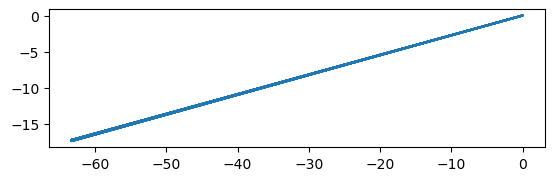

In [18]:
gdf_lines.plot()

In [19]:
gdf_lines.to_file('LINEAS.shp', driver="ESRI Shapefile")

In [20]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [21]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [22]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [23]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [24]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [25]:
gdf_lines['vehiculo'] = vehiculo

In [26]:
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-08-11 21-35-22.tlog,"LINESTRING (-63.19648 -17.37330, -63.19648 -17...",2402,DA02
1,2025-08-11 21-35-22.tlog,"LINESTRING (-63.18972 -17.37615, -63.18972 -17...",5583,DA02
2,2025-08-11 21-35-22.tlog,"LINESTRING (-63.17423 -17.37235, -63.17423 -17...",8575,DA02


<Axes: >

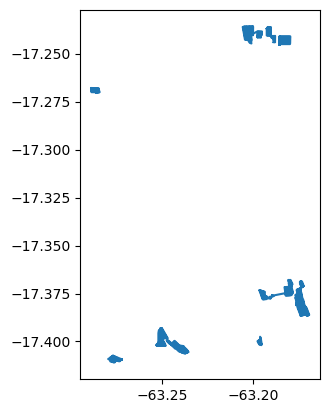

In [27]:
gdf_lines.plot()

In [28]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

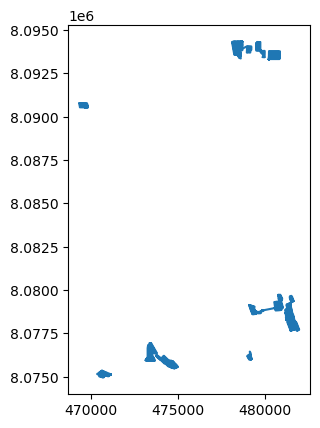

In [29]:
gdf_lines_utm.plot()

In [30]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lines_utm], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [31]:
gdf_combined

,idd,nombre,vehiculo,num_vert,id,asignado,geometry
0,-1,2025-05-02 08-32-28.tlog,DA02,2517.0,None,ORIGINAL,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,-1,2025-05-05 16-16-47.tlog,DA02,1056.0,None,ORIGINAL,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,-1,2025-05-05 16-32-05.tlog,DA02,345.0,None,ORIGINAL,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,-1,2025-05-05 21-05-04.tlog,DA02,3426.0,None,ORIGINAL,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,-1,2025-05-05 21-05-04.tlog,DA02,3207.0,None,ORIGINAL,"LINESTRING (478649.523 8093832.840, 478649.555..."
...,...,...,...,...,...,...,...
251,0,2025-08-12 05-57-10.tlog,DA02,3110.0,NaN,NaN,"LINESTRING (478201.180 8094246.871, 478201.180..."
252,0,2025-08-12 05-57-10.tlog,DA02,2986.0,NaN,NaN,"LINESTRING (479787.400 8093803.689, 479787.390..."
253,0,2025-08-12 07-47-56.tlog,DA02,853.0,NaN,NaN,"LINESTRING (479871.416 8093466.046, 479871.345..."
254,0,2025-08-12 07-47-56.tlog,DA02,3307.0,NaN,NaN,"LINESTRING (480240.500 8093307.896, 480240.532..."


In [32]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert     float64
id            object
asignado      object
geometry    geometry
dtype: object

In [33]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")

In [131]:
# lee un .bin y extrae un csv con las coordenadas

from pymavlink import mavutil
import pandas as pd

# Abrir el archivo .BIN
log = mavutil.mavlink_connection("log_93_2025-7-22-00-03-38.bin", dialect="ardupilotmega", notimestamps=False)

gps_data = []

# Leer mensajes tipo GPS
while True:
    msg = log.recv_match(type="GPS", blocking=False)
    if msg is None:
        break
    try:
        gps_data.append({
            "time": getattr(msg, "TimeMS", None),
            "lat": getattr(msg, "Lat", 0),
            "lon": getattr(msg, "Lng", 0),
            "alt": getattr(msg, "Alt", 0) / 1000,  # en metros
            "hdop": getattr(msg, "HDop", None),
            "satellites": getattr(msg, "NSats", None)
        })
    except Exception as e:
        print("Error en mensaje:", e)

# Convertir a DataFrame
df = pd.DataFrame(gps_data)

# Ver los primeros registros
print(df.head())

# Guardar a CSV
df.to_csv("gps_extraido.csv", index=False)


   time        lat        lon      alt  hdop  satellites
0  None -17.210869 -62.992451  0.25557  0.55          26
1  None -17.210869 -62.992451  0.25557  0.55          26
2  None -17.210869 -62.992451  0.25558  0.55          26
3  None -17.210869 -62.992452  0.25559  0.55          26
4  None -17.210869 -62.992452  0.25559  0.55          26


In [132]:
# lee las coordenas y las crea un geopackage

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Cargar CSV generado desde el .BIN
df = pd.read_csv("gps_extraido.csv")

# Crear columna de geometría (en EPSG:4326)
geometry = [Point(lon, lat) for lon, lat in zip(df["lon"], df["lat"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# ✅ Reproyectar a UTM Zona 20 Sur (EPSG:32720)
gdf_utm = gdf.to_crs(epsg=32720)

# Guardar en archivo GeoPackage (o .shp si prefieres)
gdf_utm.to_file("trayectoria_utm20s.gpkg", driver="GPKG")

print("✅ Archivo proyectado guardado como trayectoria_utm20s.gpkg (EPSG:32720)")


✅ Archivo proyectado guardado como trayectoria_utm20s.gpkg (EPSG:32720)


In [150]:
from pymavlink import mavutil
import pandas as pd
import datetime

# Cargar el archivo .BIN
log = mavutil.mavlink_connection("log_93_2025-7-22-00-03-38.bin")

gps_data = []

while True:
    msg = log.recv_match(type="GPS", blocking=False)
    if msg is None:
        break

    try:
        # Extraer valores clave
        gps_data.append({
            "timestamp_us": getattr(msg, "TimeUS", None),
            "gps_ms": getattr(msg, "GMS", None),
            "gps_week": getattr(msg, "GWk", None),
            "lat": getattr(msg, "Lat", 0),
            "lon": getattr(msg, "Lng", 0),
            "alt_m": getattr(msg, "Alt", 0),
            "spd_mps": getattr(msg, "Spd", 0),
            "vz_mps": getattr(msg, "VZ", 0),
            "hdop": getattr(msg, "HDop", None),
            "nsats": getattr(msg, "NSats", None),
        })
    except Exception as e:
        print("Error leyendo mensaje GPS:", e)

# Crear DataFrame
df = pd.DataFrame(gps_data)

# Escalar coordenadas si están en formato entero (como es típico)
df["lat"] = df["lat"]
df["lon"] = df["lon"]

# Convertir tiempo GPS (ms desde el inicio de la semana) a fecha real
# Semana GPS 0 comenzó el 6 de enero de 1980
gps_epoch = datetime.datetime(1980, 1, 6)
df["gps_datetime"] = df.apply(
    lambda row: gps_epoch + datetime.timedelta(weeks=row["gps_week"], milliseconds=row["gps_ms"]),
    axis=1
)

# Ver primeros registros
print(df.head())

# Guardar
df.to_csv("gps_dataframe.csv", index=False)


   timestamp_us     gps_ms  gps_week        lat        lon   alt_m  spd_mps  \
0     152643827  186501200      2376 -17.210869 -62.992451  255.57    0.053   
1     152823724  186501400      2376 -17.210869 -62.992451  255.57    0.041   
2     153023792  186501600      2376 -17.210869 -62.992451  255.58    0.050   
3     153223733  186501800      2376 -17.210869 -62.992452  255.59    0.029   
4     153443881  186502000      2376 -17.210869 -62.992452  255.59    0.040   

   vz_mps  hdop  nsats            gps_datetime  
0  -0.010  0.55     26 2025-07-22 03:48:21.200  
1   0.023  0.55     26 2025-07-22 03:48:21.400  
2   0.018  0.55     26 2025-07-22 03:48:21.600  
3  -0.022  0.55     26 2025-07-22 03:48:21.800  
4  -0.101  0.55     26 2025-07-22 03:48:22.000  
